In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_pandas
import matplotlib.pyplot as plt
import pickle
from nltk import word_tokenize

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Activation, Embedding, LSTM, Dense, Dropout, Layer, Concatenate
from keras.layers import TimeDistributed, Bidirectional, Lambda
from keras.layers import concatenate
from keras.layers.recurrent import Recurrent
from keras.layers.core import Reshape
from keras.activations import tanh, softmax
from keras.engine import InputSpec
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
# make sure gpu is available
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [18]:
K.clear_session()

# import embedding

In [5]:
# dictionaries, pretrained embeddings
with open('data/glv_w2idx.pkl', 'rb') as f:
    w2idx = pickle.load(f)
with open('data/glv_embed_matrix.pkl', 'rb') as f:
    embedding = pickle.load(f)

In [6]:
# need to append BOS ('\t') and EOS ('\n') tokens to embeddings
# give (consistently) random initialization since they don't actually mean anything
# padding already exists as '' at the end of the embedding

w2idx['\t'] = embedding.shape[0]
np.random.seed(1)
embedding = np.append(embedding, np.random.rand(1, 300), axis=0)

w2idx['\n'] = embedding.shape[0]
np.random.seed(2)
embedding = np.append(embedding, np.random.rand(1, 300), axis=0)

# dataset

In [7]:
# placeholder dataset

df = pd.DataFrame({'Sentence': ["I do not know what to say.", "The girl will not go to bed."], 
                  'Original': ["do not", "will not"],
                  'Replacement': ["don't", "won't"]})
df.head()

,Original,Replacement,Sentence
0,do not,don't,I do not know what to say.
1,will not,won't,The girl will not go to bed.


In [8]:
# preprocessing
# change from text to indices

def sent_to_word_idx(df):
    new = []
    
    for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
        
        sent = word_tokenize(row['Sentence'])
        
        # add start-of-sequence ('\t') and end-of-sequence ('\n') markers to all texts
        sent = ['\t'] + sent + ['\n']
        
        sent_indices = []
        for word in sent:
            word = word.lower()
            if word in w2idx:
                sent_indices.append(w2idx[word])
            else:
                sent_indices.append(len(w2idx))
                                
        new.append(sent_indices)
    
    df['x_word'] = new
    return df

def orig_to_place_idx(df):
    # takes the part of the sentence to be replaced and turns it into a pair of start/end indices
    
    y_start = []
    y_end = []
    
    for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
        sent = word_tokenize(row['Original'])
        sent_indices = []
        for word in sent:
            word = word.lower()
            if word in w2idx:
                sent_indices.append(w2idx[word])
            else:
                sent_indices.append(len(w2idx))
        
        # take indices and find the slice in the whole sentence
        slice_length = len(sent_indices)
        starts = [i for i, x in enumerate(row['x_word']) if x == sent_indices[0]]
        slice_idx = np.nan
        
        for potential_start in starts:
            potential_slice = row['x_word'][potential_start : potential_start + slice_length]
            if (potential_slice == np.array(sent_indices)).all():
                y_start.append(potential_start)
                y_end.append(potential_start + slice_length - 1)
                break
            
    df['y_start'] = y_start
    df['y_end'] = y_end
    return df

def repl_to_word_idx(df):
    # takes original & replacement texts and turns them into both decoder input and decoder output
    # both so that teacher forcing can be done
    
    y_rep = []
    y_orig = []
    
    for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
        sent = word_tokenize(row['Replacement'])
                
        # add start-of-sequence ('\t') and end-of-sequence ('\n') markers to all texts
        sent = ['\t'] + sent + ['\n']
        
        sent_indices = []
        for word in sent:
            word = word.lower()
            if word in w2idx:
                sent_indices.append(w2idx[word])
            else:
                sent_indices.append(len(w2idx))
                
        y_rep.append(sent_indices)
    
    for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
        sent = word_tokenize(row['Original'])
                
        # add start-of-sequence ('\t') and end-of-sequence ('\n') markers to all texts
        sent = ['\t'] + sent + ['\n']
        
        sent_indices = []
        for word in sent:
            word = word.lower()
            if word in w2idx:
                sent_indices.append(w2idx[word])
            else:
                sent_indices.append(len(w2idx))
        y_orig.append(sent_indices)
        
    df['y_orig'] = y_orig
    df['y_rep'] = y_rep
    
    return df

In [9]:
df = sent_to_word_idx(df)
df = orig_to_place_idx(df)
df = repl_to_word_idx(df)
df.head()

,Original,Replacement,Sentence,x_word,y_start,y_end,y_orig,y_rep
0,do not,don't,I do not know what to say.,"[400001, 41, 88, 36, 346, 102, 4, 203, 2, 400002]",2,3,"[400001, 88, 36, 400002]","[400001, 88, 70, 400002]"
1,will not,won't,The girl will not go to bed.,"[400001, 0, 1749, 43, 36, 242, 4, 3827, 2, 400...",3,4,"[400001, 43, 36, 400002]","[400001, 1369, 70, 400002]"


In [10]:
# extract data to arrays from df, add pre-padding

X = pad_sequences(df['x_word'], value = len(w2idx)).astype('int64')
y_rep = pad_sequences(df['y_rep'], value = len(w2idx)).astype('int64')
y_orig = pad_sequences(df['y_orig'], value = len(w2idx)).astype('int64')

# set up target data from output sequence, 1 timestep off from y_rep
#y_rep_output

y_start = to_categorical(np.array(df['y_start']), num_classes = X.shape[1], dtype = 'int64')
y_end = to_categorical(np.array(df['y_end']), num_classes = X.shape[1], dtype = 'int64')
y_rep_cat = np.array([to_categorical(x, num_classes = embedding.shape[0]) for x in y_rep]) 

# training model

In [19]:
num_units = 128 # I think 512 or 1028 is standard - lessening for memory purposes for now
epochs = 50
batch_size = 2
learning_rate = 0.1

input_len = X.shape[1]
orig_len = y_orig.shape[1]
repl_len = y_rep.shape[1]

In [20]:
# input sentences in form of word indices
main_input = Input(shape = (input_len,), dtype = 'int64', name = 'main_input')
repl_input = Input(shape = (repl_len,), dtype = 'int64', name = 'repl_input')
orig_input = Input(shape = (orig_len,), dtype = 'int64', name = 'orig_input')

# embedding layer
# note for later: can use mask_zero parameter in embedding layer, but would need to go back and change some indices
embedding_layer = Embedding(input_dim = embedding.shape[0],
                      output_dim = embedding.shape[1],
                      weights = [embedding],
                      trainable = False, 
                      name = 'embedding_layer')

input_embed = embedding_layer(main_input)
repl_embed = embedding_layer(repl_input)
orig_embed = embedding_layer(orig_input)

In [28]:
# define PtrNetLSTM

class PtrNetLSTM(LSTM):
    # https://keras.io/layers/writing-your-own-keras-layers/
    
    def __init__(self, *args, **kwargs):
        super(PtrNetLSTM, self).__init__(*args, **kwargs)
    
    def build(self, input_shape):
        
        super(PtrNetLSTM, self).build(input_shape)
        pass
    
    def call(self, x):
        pass
    
    def compute_output_shape(self, input_shape):
        pass

'''
class PointerLSTM(LSTM):
#    def __init__(self, hidden_shape, *args, **kwargs):
        self.hidden_shape = hidden_shape
        self.input_length = []
#        super(PointerLSTM, self).__init__(*args, **kwargs)

#    def get_initial_states(self, x_input):
#        return Recurrent.get_initial_state(self, x_input)

    def build(self, input_shape):
        super(PointerLSTM, self).build(input_shape)
        self.input_spec = [InputSpec(shape=input_shape)]
        self.W1 = self.add_weight(name="W1",
                                  shape=(self.hidden_shape, 1),
                                  initializer="uniform",
                                  trainable=True)
        self.W2 = self.add_weight(name="W2",
                                  shape=(self.hidden_shape, 1),
                                  initializer="uniform",
                                  trainable=True)
        self.vt = self.add_weight(name="vt",
                                  shape=(input_shape[1], 1),
                                  initializer='uniform',
                                  trainable=True)
        #self.trainable_weights += [self.W1, self.W2, self.vt]

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        en_seq = x
        x_input = x[:, input_shape[1] - 1, :]
        x_input = K.repeat(x_input, input_shape[1])
        initial_states = self.get_initial_states(x_input)

        constants = super(PointerLSTM, self).get_constants(x_input)
        constants.append(en_seq)
        preprocessed_input = self.preprocess_input(x_input)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                             initial_states,
                                             go_backwards=self.go_backwards,
                                             constants=constants,
                                             input_length=input_shape[1])

        return outputs

    def step(self, x_input, states):
        # print "x_input:", x_input, x_input.shape
        # <TensorType(float32, matrix)>

        input_shape = self.input_spec[0].shape
        en_seq = states[-1]
        _, [h, c] = super(PointerLSTM, self).step(x_input, states[:-1])

        # vt*tanh(W1*e+W2*d)
        dec_seq = K.repeat(h, input_shape[1])
        Eij = TimeDistributed(Dense(en_seq, self.W1, output_dim=1))
        Dij = TimeDistributed(Dense(dec_seq, self.W2, output_dim=1))
        U = self.vt * tanh(Eij + Dij)
        U = K.squeeze(U, 2)

        # make probability tensor
        pointer = softmax(U)
        return pointer, [h, c]

#    def get_output_shape_for(self, input_shape):
#        # output shape is not affected by the attention component
#        return (input_shape[0], input_shape[1], input_shape[1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[1])

In [21]:
### get indices

lstm = LSTM(return_sequences = False, units = num_units, name = 'lstm')(input_embed)
# lstm = LSTM(return_sequences = True, units = num_units, name = 'lstm')(input_embed)

y_start_output = Dense(input_len, activation = 'softmax', name = 'y_start_output')(lstm)
y_end_output = Dense(input_len, activation = 'softmax', name = 'y_end_output')(lstm)
# y_start_output = PointerLSTM(input_len, activation = 'softmax', name = 'y_start_output')(lstm)
# y_end_output = PointerLSTM(input_len, activation = 'softmax', name = 'y_end_output')(lstm)
# change inputs to (hidden_shape = num_units, units = num_units) ???

In [22]:
### connect indices to main_input

## later use this to slice and concatenate with context
## in the meantime just assume y_orig is somehow the output

#y_indices = concatenate([K.argmax(y_start_output, axis = 1), K.argmax(y_end_output, axis = 1)])
#y_start_sparse = Lambda(lambda x : K.argmax(x, axis = 1))(y_start_output)
#y_end_sparse = Lambda(lambda x : K.argmax(x, axis = 1))(y_end_output)
#y_start_reshape = Reshape((1,))(y_start_sparse)
#y_end_reshape = Reshape((1,))(y_end_sparse)
#return_input = concatenate([y_start_reshape, y_end_reshape, main_input], axis = 1)

In [23]:
### feed encoder input (main_input), decoder input (repl_input) and sliced replacement text to enc-dec system

# these should change later to some sort of context-based or conditional model
# also with attention

# decoder given 2*units to accept bidirectional outputs
encoder = Bidirectional(LSTM(return_state = True, units = num_units), name = "encoder")
decoder = LSTM(return_sequences = True, return_state = True, name = "decoder", units = 2 * num_units)

# sequence is unnecessary for the encoder - just states, to start the decoder correctly
# state and sequence for decoder will be necessary in inference, but not right now
enc_output, enc_h_forward, enc_c_forward, enc_h_backward, enc_c_backward = encoder(orig_embed)
enc_h = Concatenate()([enc_h_forward, enc_h_backward])
enc_c = Concatenate()([enc_c_forward, enc_c_backward])
dec_output, _, _ = decoder(repl_embed, initial_state = [enc_h, enc_c])

# Dropout?

y_rep_output = TimeDistributed(Dense(embedding.shape[0], activation='softmax'), 
                               name = 'y_rep_output')(dec_output)

In [24]:
#### define & train model

model = Model(inputs = [main_input, orig_input, repl_input], outputs = [y_start_output, y_end_output, y_rep_output])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model.fit([X, y_orig, y_rep], [y_start, y_end, y_rep_cat], epochs = epochs, batch_size = batch_size)

Epoch 1/50
2/2 [==============================] - 7s 3s/step - loss: 17.2116 - y_start_output_loss: 2.1692 - y_end_output_loss: 2.1433 - y_rep_output_loss: 12.8991 - y_start_output_acc: 0.0000e+00 - y_end_output_acc: 0.5000 - y_rep_output_acc: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 96ms/step - loss: 15.9660 - y_start_output_loss: 1.5652 - y_end_output_loss: 1.5484 - y_rep_output_loss: 12.8524 - y_start_output_acc: 1.0000 - y_end_output_acc: 0.5000 - y_rep_output_acc: 0.7500
Epoch 3/50
2/2 [==============================] - 0s 84ms/step - loss: 14.9787 - y_start_output_loss: 1.0974 - y_end_output_loss: 1.0897 - y_rep_output_loss: 12.7916 - y_start_output_acc: 1.0000 - y_end_output_acc: 0.5000 - y_rep_output_acc: 0.7500
Epoch 4/50
2/2 [==============================] - 0s 88ms/step - loss: 14.2311 - y_start_output_loss: 0.7654 - y_end_output_loss: 0.7684 - y_rep_output_loss: 12.6973 - y_start_output_acc: 1.0000 - y_end_output_acc: 1.0000 - y_rep_output_acc: 0.750

Epoch 34/50
2/2 [==============================] - 0s 86ms/step - loss: 1.2936 - y_start_output_loss: 1.5257e-04 - y_end_output_loss: 1.0992e-04 - y_rep_output_loss: 1.2934 - y_start_output_acc: 1.0000 - y_end_output_acc: 1.0000 - y_rep_output_acc: 1.0000
Epoch 35/50
2/2 [==============================] - 0s 87ms/step - loss: 1.1956 - y_start_output_loss: 1.4524e-04 - y_end_output_loss: 1.0369e-04 - y_rep_output_loss: 1.1953 - y_start_output_acc: 1.0000 - y_end_output_acc: 1.0000 - y_rep_output_acc: 0.8750
Epoch 36/50
2/2 [==============================] - 0s 80ms/step - loss: 1.1194 - y_start_output_loss: 1.3883e-04 - y_end_output_loss: 9.8353e-05 - y_rep_output_loss: 1.1191 - y_start_output_acc: 1.0000 - y_end_output_acc: 1.0000 - y_rep_output_acc: 0.8750
Epoch 37/50
2/2 [==============================] - 0s 83ms/step - loss: 1.0593 - y_start_output_loss: 1.3320e-04 - y_end_output_loss: 9.3703e-05 - y_rep_output_loss: 1.0591 - y_start_output_acc: 1.0000 - y_end_output_acc: 1.0000 - y

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 10)           0                                            
__________________________________________________________________________________________________
repl_input (InputLayer)         (None, 4)            0                                            
__________________________________________________________________________________________________
orig_input (InputLayer)         (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     multiple             120000900   main_input[0][0]                 
                                                                 repl_input[0][0]                 
          

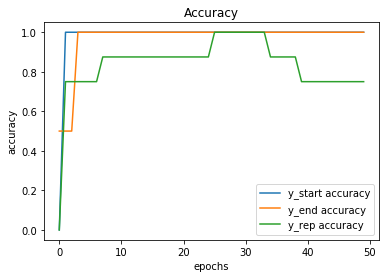

In [25]:
plt.plot(history.history['y_start_output_acc'], label='y_start accuracy')
plt.plot(history.history['y_end_output_acc'], label='y_end accuracy')
plt.plot(history.history['y_rep_output_acc'], label='y_rep accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

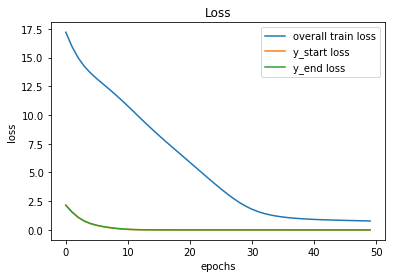

In [26]:
plt.plot(history.history['loss'], label='overall train loss')
plt.plot(history.history['y_start_output_loss'], label='y_start loss')
plt.plot(history.history['y_end_output_loss'], label='y_end loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# inference mode

# tbd

In [ ]:

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

In [27]:
# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
def define_nmt(hidden_size, batch_size, en_timesteps, en_vsize, fr_timesteps, fr_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, fr_timesteps - 1, fr_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(en_timesteps, en_vsize), name='encoder_inputs')
        decoder_inputs = Input(shape=(fr_timesteps - 1, fr_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = Bidirectional(GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru'), name='bidirectional_encoder')
    encoder_out, encoder_fwd_state, encoder_back_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = Bidirectional(GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru'), name='bidirectional_decoder')
    decoder_out, decoder_fwd_state, decoder_back_state = decoder_gru(decoder_inputs, initial_state=[encoder_fwd_state, encoder_back_state])

    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(fr_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy')

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, fr_vsize), name='decoder_word_inputs')
    encoder_inf_states = Input(batch_shape=(batch_size, en_timesteps, 2*hidden_size), name='encoder_inf_states')
    decoder_init_fwd_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_fwd_init')
    decoder_init_back_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_back_init')

    decoder_inf_out, decoder_inf_fwd_state, decoder_inf_back_state = decoder_gru(decoder_inf_inputs, initial_state=[decoder_init_fwd_state, decoder_init_back_state])
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_fwd_state, decoder_init_back_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_fwd_state, decoder_inf_back_state])

    return full_model, encoder_model, decoder_model